First the data is imported and classifications updated

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Met = pd.read_csv('Met430k.csv', sep = ',', engine = 'python')



In [3]:
Met.count()

Unnamed: 0             427592
Object ID              427592
object_number          427592
artist_nationality     192674
object_begin_date      427592
object_end_date        427592
credit_line            426965
country                427592
classification         374667
medium                 421276
artist_display_name    256333
artist_display_bio     234364
culture                186901
object_name            424522
link                   427592
acq_year               396331
Class_General          427592
dtype: int64

In [4]:
ClusterData=Met

The lower estimate for the objects creation date has a number of repetitions - indicating accuracy varies and often to nearest 100 years. The data has a large range with a long tail of historic/prehistoric items. This skews the standard deviation, often used to normalise data for clustering. We can mitigate this by applying a Tukey fence - ignoring data which sits outside 1.5x interquartile range from the upper or lower quartile.

In [5]:
ClusterData.object_begin_date.value_counts().head(10)

 1800    20490
 1700    14472
 1900     6494
-500      6231
 1600     6142
-530      6119
 1890     5314
 1850     5083
 1500     5033
 1880     4422
Name: object_begin_date, dtype: int64

In [6]:
ClusterData.object_begin_date.describe()

count    427592.000000
mean       1314.351108
std        1664.265032
min     -400000.000000
25%        1530.000000
50%        1797.000000
75%        1890.000000
max        5000.000000
Name: object_begin_date, dtype: float64

First we get rid of some erronous dates

In [7]:
mistakes = ClusterData.loc[ClusterData.object_begin_date > 2019]
ClusterData=ClusterData.loc[ClusterData.object_begin_date <= 2019]
mistakes.object_begin_date.describe()

count       2.0
mean     5000.0
std         0.0
min      5000.0
25%      5000.0
50%      5000.0
75%      5000.0
max      5000.0
Name: object_begin_date, dtype: float64

In [8]:
IQR = np.percentile(ClusterData.object_begin_date,75)-np.percentile(ClusterData.object_begin_date,25)
print(IQR)
cutoff = np.percentile(ClusterData.object_begin_date,25)-1.5*IQR
print(cutoff)

360.0
990.0


In [9]:
outliers = ClusterData.loc[ClusterData.object_begin_date < cutoff]
cutData = ClusterData.loc[(ClusterData.object_begin_date >= cutoff)]
cutData.object_begin_date.describe()

count    347108.000000
mean       1787.881991
std         167.155292
min         990.000000
25%        1700.000000
50%        1833.000000
75%        1907.000000
max        2018.000000
Name: object_begin_date, dtype: float64

In [10]:
outliers.object_begin_date.describe()

count     80482.000000
mean       -728.015246
std        3075.130237
min     -400000.000000
25%       -1353.000000
50%        -530.000000
75%           0.000000
max         980.000000
Name: object_begin_date, dtype: float64

By rerunning statistics separately on the core and outlier data, we get a more nuanced picture of the distribution:
about 80% of the artwork comes from the last millenium, 5% comes from the the 1st millenium a.d. and the rest stretches out into prehistory. It is also apparent that the cut data still has a skewed distribution. We can plot a histogram to get a better sense of the distribution

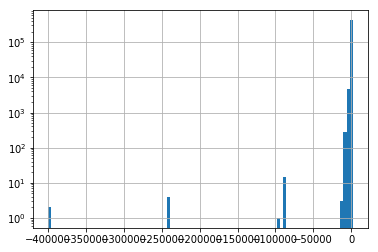

In [11]:
ClusterData.object_begin_date.hist(bins=100,log=True)

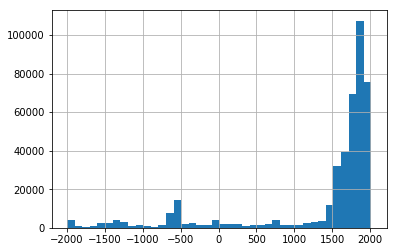

In [12]:
ClusterData.loc[(ClusterData.object_begin_date >= -2000)].object_begin_date.hist(bins=40)

There are some concentrations of datapoints in pre-history, but this may reflect the tendency for age estimates to be bounded at rounded dates. Interestingly by plotting more recent artwork on a log chart, there appear to be a power-law type relationship on the amount of art present, with a noticeable step-up around 1500 - an American effect?

(array([  1214.,   1840.,   2374.,   2729.,   3502.,  10332.,  20562.,
         31342.,  40361.,  69641., 105880.,  57314.]),
 array([1000.        , 1084.83333333, 1169.66666667, 1254.5       ,
        1339.33333333, 1424.16666667, 1509.        , 1593.83333333,
        1678.66666667, 1763.5       , 1848.33333333, 1933.16666667,
        2018.        ]),
 <a list of 12 Patch objects>)

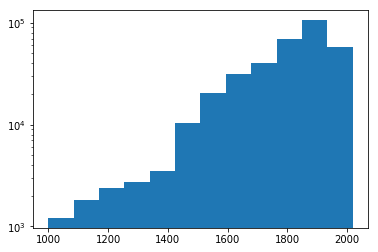

In [13]:
plt.hist(ClusterData.loc[ClusterData.object_begin_date >= 1000].object_begin_date,bins=12,log=True)

The skewness of the data possibly reflects both a survival/interest bias but also the increasing speed of changes in artwork. Either way, when normalising the distance function in our clustering a linear scale function may not be appropriate - 100 years of distance in modern times is far more signfiicant than 100 years of distance in historical times.

In [14]:
for i in ClusterData.index:
        ClusterData.at[i, 'normalised_age'] = (np.log((2120-ClusterData.at[i, 'object_begin_date']))-5.6)*2

/Users/terry/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/terry/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Date transformation (to log of artwork age) standardised to a mean of ~0 and std .dev. of 2. The implication of this is that an artwork from today is a distance of 1 from a piece from the 1950s, which is 1 distance away from the 1850s which is 1 away from 1650s and so on.

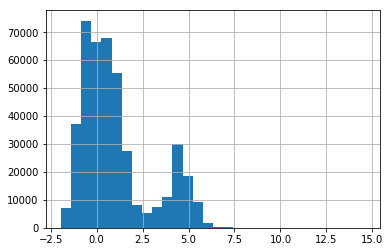

In [15]:
ClusterData.normalised_age.hist(bins=30,log=False)

In [16]:
ClusterData.normalised_age.describe()

count    427590.000000
mean          1.014223
std           1.921218
min          -1.950054
25%          -0.323841
50%           0.355305
75%           1.560245
max          14.609012
Name: normalised_age, dtype: float64

0=-2000, 0.2= 400, 0.4 =1000, 0.6=1500, 0.8= 1776 1 =2000

<h2> Adding pairwise distance to the clustering</h2>
lat, longs can't be stuck into DBScan normally due to the global scale.

In [19]:
import math

def Haversine(origin, destination):
    #Calculate the Haversine distance  - not scaled for earth radius.
    lat1, lon1 = origin
    lat2, lon2 = destination
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return c

In [20]:
geocodes = pd.read_csv('geocodes.csv', sep = ',', engine = 'python')

In [21]:
geocodes.country.value_counts()

United States       113767
France               61254
Italy                41026
Egypt                33500
United Kingdom       31654
Japan                23263
Greece               21588
Germany              18047
China                16460
Netherlands          11438
Iran                  8698
Spain                 4803
India                 4134
Peru                  3519
Mexico                3419
Brazil                3178
Cyprus                2912
Austria               2820
Indonesia             2728
Zaire                 2378
Czech Republic        1584
Switzerland           1473
Canada                1350
Turkey                 983
Iraq                   918
Ireland                911
Papua New Guinea       882
Nigeria                682
Syria                  601
Thailand               553
                     ...  
Cambodia                 5
Kiribati                 5
Honduras                 5
Nicaragua                5
Vietnam                  4
Ukraine                  4
G

In [22]:
geocodes.describe()

,Object ID,coordX,coordY
count,427592.000000,4.275920e+05,4.275920e+05
mean,372414.648611,2.769896e+06,3.885277e+06
std,223464.293182,4.958926e+06,2.739408e+06
min,1.000000,-1.698472e+07,-1.054443e+07
25%,207334.750000,-1.198170e+06,7.068348e+05
50%,365383.500000,5.476383e+06,4.351821e+06
75%,550536.250000,6.339757e+06,5.537386e+06
max,825751.000000,1.621832e+07,1.164035e+07


In [27]:
geocodes["coordX"].std()

4958925.7182077365

In [25]:
SpatioTemporalData=ClusterData[["Object ID","normalised_age"]].merge(geocodes[["Object ID","coordX","coordY"]],how="left",left_on="Object ID",right_on="Object ID")

In [28]:
meanX=geocodes["coordX"].mean()
stdX=geocodes["coordX"].std()
meanY=geocodes["coordY"].mean()
stdY=geocodes["coordY"].std()

for i in SpatioTemporalData.index:
        SpatioTemporalData.at[i, 'coordX'] = (geocodes.at[i, 'coordX']-meanX)/stdX
        SpatioTemporalData.at[i, 'coordY'] = (geocodes.at[i, 'coordY']-meanY)/stdY

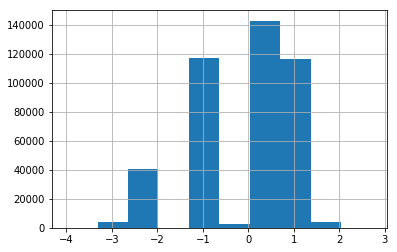

In [31]:
SpatioTemporalData.coordX.hist(bins=10)

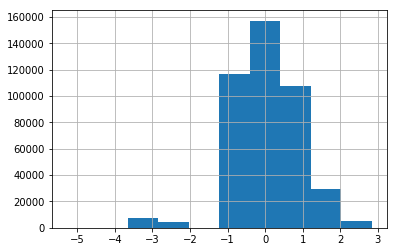

In [32]:
SpatioTemporalData.coordY.hist(bins=10)

In [45]:

import scipy
from sklearn.cluster import DBSCAN
from sklearn import metrics
import functools


def metricFunction(x,y,mu):
    time = abs(x[1]-y[1])  
    space = Haversine((x[3],x[2]),(y[3],y[2]))
    distance = time + mu * space
    return distance

def dbscanFitMetric(data, eps, minSamples,mu):
    metric_weighted=functools.partial(metricFunction,mu=mu)
    #DBSCAN for non Year Data
    dbscan = DBSCAN(eps = eps, metric = metric_weighted, min_samples = minSamples)
    dbscan.fit(data)
    dbscan_labels = dbscan.labels_
    silh = metrics.silhouette_score(data, dbscan_labels)
    print("Silhouette Score: ", silh)
    clusters = pd.DataFrame(dbscan_labels)
    clusters['Count'] = 1
    clusters.columns = ['Cluster ID', 'Count']
    print(clusters.groupby('Cluster ID').sum().head())
    
    return dbscan_labels

def dbscanFit(data, eps, minSamples):
    #DBSCAN for non Year Data
    dbscan = DBSCAN(eps = eps,  min_samples = minSamples)
    dbscan.fit(data)
    dbscan_labels = dbscan.labels_
    silh = metrics.silhouette_score(data, dbscan_labels)
    print("Silhouette Score: ", silh)
    clusters = pd.DataFrame(dbscan_labels)
    clusters['Count'] = 1
    clusters.columns = ['Cluster ID', 'Count']
    print(clusters.groupby('Cluster ID').sum().head())
    
    return dbscan_labels



In [47]:
SpatioTemporalData.iloc[1:,1:].describe()

,normalised_age,coordX,coordY
count,427589.000000,427589.000000,427589.000000
mean,1.014225,0.000002,0.000003
std,1.921220,1.000001,0.999999
min,-1.950054,-3.983648,-5.267456
25%,-0.323841,-0.800187,-1.160266
50%,0.355305,0.545781,0.170308
75%,1.560245,0.719886,0.603090
max,14.609012,2.711963,2.830931


In [50]:
dbscanFit(SpatioTemporalData.iloc[1:100000,1:],eps=0.5,minSamples=100)

KeyboardInterrupt: 